## Prepare python environment


In [1]:
# Installs required packages
!apt install libgraphviz-dev
!pip install pomegranate matplotlib pygraphviz

# Press "Restart Runtime" after running this cell, before going to the rest of the code.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
random_state=5 # use this to control randomness across runs e.g., dataset partitioning

## Preparing the Statslog (Heart) Dataset (2 points)

---


We will use heart dataset from UCI machine learning repository. Details of this data can be found [here](https://archive.ics.uci.edu/ml/datasets/statlog+(heart)). 
The dataset contains the following features with their corresponding feature types:
1. age in years (real)
2. sex (binary; 1=male/0=female)
3. cp: chest pain type (categorical)
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital) (real)
5. chol: serum cholestorol in mg/dl (real)
6. fbs: (fasting blood sugar > 120 mg/dl) (binary; 1=true/0=false)
7. restecg: resting electrocardiographic results (categorical)
8. thalach: maximum heart rate achieved (real)
9. exang: exercise induced angina (1 = yes; 0 = no) (binary)
10. oldpeak: ST depression induced by exercise relative to rest (real)
11. slope: the slope of the peak exercise ST segment (ordinal)
12. ca: number of major vessels colored by flourosopy (real)
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect. (categorical)

The objective is to determine whether a person has heart disease or not based on these features.

Note: We will use a subset of the above features because the [scikit-learn implementation of Decision Trees does not support categorical variables](https://scikit-learn.org/stable/modules/tree.html#tree). 

### Loading the dataset

#### There are a total of 303 entries in this dataset. First 13 columns are features and the last column indicates whether the person has heart disease or not.

In [5]:
# Download and load the dataset
import os
if not os.path.exists('heart.csv'): 
    !wget https://raw.githubusercontent.com/JHA-Lab/ece364_2022/master/dataset/heart.csv 
df = pd.read_csv('heart.csv')


# keep real valued features and the target feature
ind_non_categorical_features=np.array([0,3,4,7,9,11,-1])
non_categorical_features=df.columns[ind_non_categorical_features]

df=df[non_categorical_features]

FEATURE_NAMES=df.drop('target',axis=1).columns

# Display the first five instances in the dataset
df.head()

--2022-10-29 20:47:36--  https://raw.githubusercontent.com/JHA-Lab/ece364_2022/master/dataset/heart.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11024 (11K) [text/plain]
Saving to: ‘heart.csv’

heart.csv           100%[===================>]  10.77K  --.-KB/s    in 0s      

2022-10-29 20:47:36 (82.0 MB/s) - ‘heart.csv’ saved [11024/11024]



,age,trestbps,chol,thalach,oldpeak,ca,target
0,63,145,233,150,2.3,0,1
1,37,130,250,187,3.5,0,1
2,41,130,204,172,1.4,0,1
3,56,120,236,178,0.8,0,1
4,57,120,354,163,0.6,0,1


In [ ]:
# Check the datatype of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   trestbps  303 non-null    int64  
 2   chol      303 non-null    int64  
 3   thalach   303 non-null    int64  
 4   oldpeak   303 non-null    float64
 5   ca        303 non-null    int64  
 6   target    303 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 16.7 KB


#### Look at some statistics of the data using the `describe` function in pandas. See [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) details about this function.

In [ ]:
# Display some statistics of the data
df.describe()

,age,trestbps,chol,thalach,oldpeak,ca,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.729373,0.544554
std,9.082101,17.538143,51.830751,22.905161,1.161075,1.022606,0.498835
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000,1.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,1.000000


1. Count tells us the number of Non-empty rows in a feature.

2. Mean tells us the mean value of that feature.

3. Std tells us the Standard Deviation Value of that feature.

4. Min tells us the minimum value of that feature.

5. 25%, 50%, and 75% are the percentile/quartile of each feature.

6. Max tells us the maximum value of that feature.

#### Look at the distributions of some features across the population. See [here](https://seaborn.pydata.org/generated/seaborn.distplot.html) for details. These have been done for you.

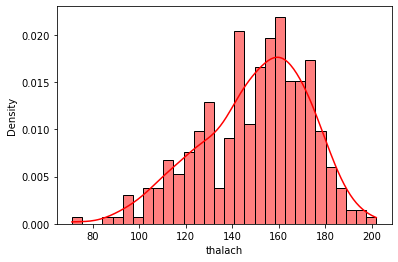

In [ ]:
sns.histplot(df['thalach'],bins=30,color='red',stat="density",kde=True)

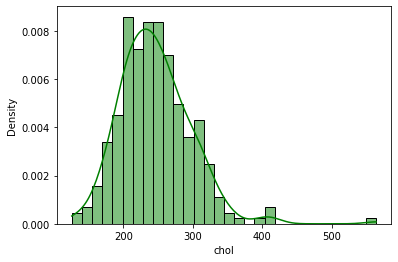

In [ ]:
sns.histplot(df['chol'],bins=30,color='green',stat='density',kde=True)

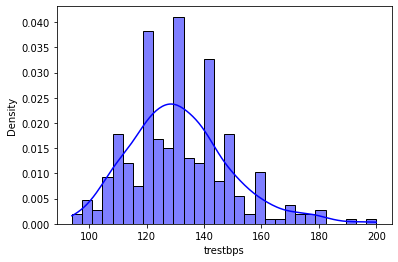

In [ ]:
sns.histplot(df['trestbps'],bins=30,color='blue',stat='density',kde=True)

#### Plot histogram of heart disease with age. This has been done for you.

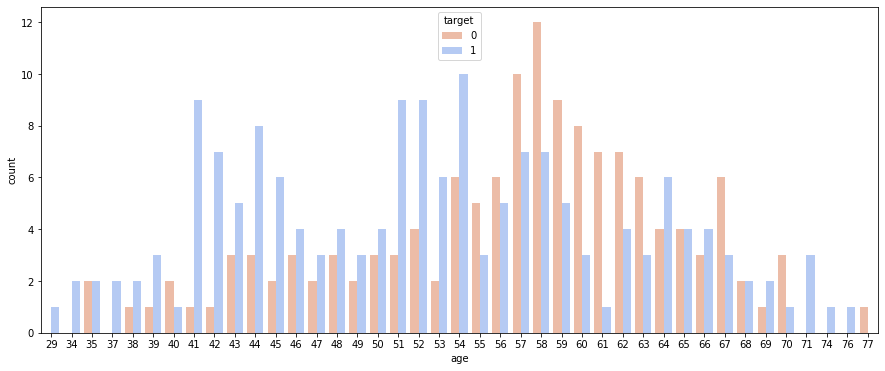

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(x='age',data = df, hue = 'target',palette='coolwarm_r')
plt.show()

### Extract target and descriptive features (1 point)


In [6]:
# Store all the features from the data in X
X= df.drop('target',axis=1)
# Store all the labels in y
y= df['target']
print(X.shape)
print(y.shape)

(303, 6)
(303,)


In [7]:
# Convert data to numpy array
X = X.to_numpy()
y = y.to_numpy()

### Create training and validation datasets (1 point)

Split the data into training and validation sets using `train_test_split`.  See [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for details. To get consistent result while splitting, set `random_state` to the value defined earlier. We use 80% of the data for training and 20% of the data for validation. 

In [8]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.2,random_state=random_state) # 80% training and 20% validation

## Training probability-based classifiers (18 points)


### Exercise 1: Learning a Naive Bayes Model (9 points)

#### We will use the `pomegranate` library to train a Naive Bayes Model. Review ch.6 and see [here](https://pomegranate.readthedocs.io/en/latest/NaiveBayes.html) for more details. 

In [9]:
from pomegranate.distributions import NormalDistribution, ExponentialDistribution, DiscreteDistribution 
from pomegranate.NaiveBayes import NaiveBayes
from pomegranate.BayesClassifier import BayesClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
import math

np.random.seed(random_state)

#### Exercise 1a: Fit naive bayes model using a single distribution type (2 points)

#### Train one naive bayes model using a normal distribution per feature. Train another naive bayes model using an exponential distribution per feature. Hint: use NormalDistribution or ExponentialDistribution and NaiveBayes.from_samples() to fit the model to the data.

#### Report the training and validation set accuracies for each model. Hint: use accuracy_score()


In [10]:
for distribution_obj in [NormalDistribution, ExponentialDistribution]:
    print(distribution_obj)
    pom_model=NaiveBayes.from_samples(distribution_obj,X_train,y_train)
    print("training acc: %.5f" %accuracy_score(y_train,pom_model.predict(X_train)))
    print("validation acc: %.5f" %accuracy_score(y_val,pom_model.predict(X_val)))


<class 'pomegranate.distributions.NormalDistribution.NormalDistribution'>
training acc: 0.73967
validation acc: 0.81967
<class 'pomegranate.distributions.ExponentialDistribution.ExponentialDistribution'>
training acc: 0.75207
validation acc: 0.78689


#### Exercise 1b: Fit a naive bayes model using different feature distributions (3 points)

#### Visualize the feature distributions (done for you below) to determine which distribution ( normal or exponential) better models a specific feature. 

#### Train a Naive Bayes classifier using this set of feature-specific distributions. Hint: use NormalDistribution or ExponentialDistribution and NaiveBayes.from_samples() to fit the model to the data.

#### Report the training and validation set accuracies for the model. Hint: use accuracy_score()

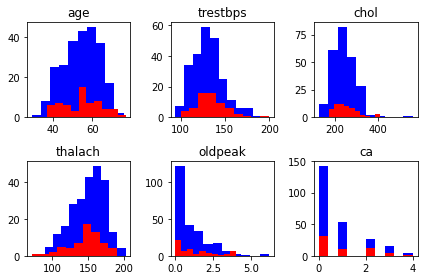

In [11]:
# visualization code

num_cols=3
num_rows=int(len(FEATURE_NAMES)/num_cols) if len(FEATURE_NAMES)%num_cols == 0 else int(math.ceil(len(FEATURE_NAMES)/num_cols))
fig,ax=plt.subplots(num_rows,num_cols)

for ft_index in np.arange(X_train.shape[1]):
    ax[ft_index//num_cols,ft_index%num_cols].hist(X_train[:,ft_index], color='blue')
    ax[ft_index//num_cols,ft_index%num_cols].hist(X_val[:,ft_index], color='red')
    ax[ft_index//num_cols,ft_index%num_cols].set_title(FEATURE_NAMES[ft_index])
    
fig.tight_layout()

In [12]:

distribution_obj=[NormalDistribution, NormalDistribution, NormalDistribution,
                  NormalDistribution, ExponentialDistribution, ExponentialDistribution]
pom_model=NaiveBayes.from_samples(distribution_obj,X_train,y_train)
print("training acc: %.5f" %accuracy_score(y_train,pom_model.predict(X_train)))
print("validation acc %.5f" %accuracy_score(y_val,pom_model.predict(X_val)))

training acc: 0.74793
validation acc 0.78689


#### Comment on any performance difference between this model and the models trained in Ex. 1a. (1 point)

A model fit using a distribution tailored per feature has similar performance as the models from Ex. 1a. The reason is that features follows neither normal distribution nor exponential distribution strictly. For example, the "normal distribution" of the **thalach** feature is skew. Thus, using the tailored distribution per feature does not help much to improve performance in this case.
 
**Note:** this can be somewhat subjective so accept any reasonable answer.

#### Exercise 1c: Fit a naive bayes model on categorical features (2 points)

#### Besides fitting a naive bayes model on the continuous features, one can fit a naive bayes model on categorical features derived from binning the continuous features, and then compute a probability mass function for each categorical feature.

#### Bin the features by varying the strategy among {equal-width binning, equal-frequency binning}. For each binning strategy, vary the number of bins among {3,10,50}. Hint: use [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer.get_params) by modifying n_bins and strategy and setting encode="ordinal" to map the labels to numerical categories.

#### For each binning setting tried above, fit a naive bayes model on the binned version of the training set. Hint: use DiscreteDistribution to model the categorical features and NaiveBayes.from_samples() to fit the model to the data.

#### Report the training and validation set accuracy for each model trained and evaluated on binned versions of the training and validation sets respectively.

**Note:** You may see some "UserWarning"s when you run your code in this part. You can ignore them if you believe they won't affect your results.

In [13]:
for strategy in ['uniform', 'quantile']: 
    print(strategy)
    for n_bins in [3,10,50]:
        
        discretizer=KBinsDiscretizer(n_bins=n_bins,encode='ordinal',strategy=strategy)
        X_train_binned=discretizer.fit_transform(X_train)
        X_val_binned=discretizer.transform(X_val)

        pom_model=NaiveBayes.from_samples(DiscreteDistribution,X_train_binned,y_train)
        print("num bins : %d"%n_bins)
        print("training acc: %.5f" %accuracy_score(y_train,pom_model.predict(X_train_binned)))
        print("validation acc: %.5f" %accuracy_score(y_val,pom_model.predict(X_val_binned)))


uniform
num bins : 3
training acc: 0.71074
validation acc: 0.77049
num bins : 10
training acc: 0.76446
validation acc: 0.67213
num bins : 50
training acc: 0.71901
validation acc: 0.70492
quantile
num bins : 3
training acc: 0.76033
validation acc: 0.72131
num bins : 10
training acc: 0.78512
validation acc: 0.80328
num bins : 50
training acc: 0.62397
validation acc: 0.60656


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." %

#### Briefly explain any performance difference between equal-width and equal-frequency binning. Also comment on the effect of increasing the number of bins (see ch.3). (1 point)

Equal-frequency binning does better than equal-width binning because it can better model the distribution in denser regions of the support. Given the features tend to follow normal or exponential distributions, this makes equal-frequency binning more advantageous for the dataset.

Increasing the number of bins used by equal-frequency binning improves the performance at the beginning, because the binned features better represent the data distribution. However, setting the number of bins too high can degrade the performance, most likely due to too many empty bins (hence bad representation of the training and validation distributions). 

Increasing the number of bins used by equal-width binning improves the training performance but degrades the validation performance at the beginning, because the binned features better represent the training distribution but the number of bins is too high for the validation distribution (overfitting). Increasing the number of bins used by equal-width binning even more hurts the training performance, because the number of bins is also too high for the training distribution now.

**Note:** There may be some variability in the actual performance scores, but the overall trends should remain the consistent. Setting the seeds did not the resolve the issue (there may be some issues with this see [here](https://github.com/jmschrei/pomegranate/issues/925)).

### Exercise 2: Learning a Bayes Net (9 points)

#### We will use the `pomegranate` library to train a Bayes Net to assess whether relaxing the assumption in Naive bayes (i.e., all features are independent given the target feature) could improve the classification model. Review ch.6 and see [here](https://pomegranate.readthedocs.io/en/latest/BayesianNetwork.html) for more details. 

#### Exercise 2a: Create a categorical version of the dataset (1 point)

#### Create categorical versions of the training and validation sets by using equal-frequency binning with the number of bins set to 3 (as in Ex. 1c).

#### Use these datasets for training and evaluating the bayes net models in the following exercises. 

**Note:** This is done because pomegranate currently only supports bayes net over categorical features.

In [14]:
discretizer=KBinsDiscretizer(n_bins=3,encode='ordinal',strategy='quantile')

#discretizer.fit(X_train)
#X_train_binned=discretizer.transform(X_train)

X_train_binned=discretizer.fit_transform(X_train)
X_val_binned=discretizer.transform(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


#### Exercise 2b: Construct a Bayes net (3 points)

#### Construct and train a Bayes net in which the **trestbps** (resting blood pressure) feature node is a parent of the **heart disease** feature node (only these 2 nodes should be in the net). Use construct_and_train_bayes_net (defined below) by passing in the binned training dataset and specifying the index of the parent feature node.

#### Construct and train another Bayes net in which the **ca** (number of major vessels colored by flourosopy) feature node is a parent of the **heart disease** feature node (only these 2 nodes should be in the net). Use construct_and_train_bayes_net (defined below) by passing in the binned training dataset and specifying the index of the parent feature node.

#### Report the training and validation accuracies of each Bayes Net. Use get_performance (defined below) by passing in the trained bayes net, binned datasets, and specifying the index of the parent feature node.

In [15]:
from pomegranate import *

"""
X_train_binned: ndarray (# instances, # features) This is the binned version of the training set
y_train: 1darray (# instances,)
ind_chosen_parent_features: 1d numpy array encodes the indices of the features relative to FEATURE_NAMES. 
                            These indices correspond to features that are parent nodes of the heart disease node. 
ind_chosen_child_features: 1d numpy array encodes the indices of the features relative to FEATURE_NAMES. 
                            These indices correspond to features that are children nodes of the heart disease node.
                            
Returns a BayesianNetwork representing the trained bayes net
"""
def construct_and_train_bayes_net(X_train_binned,
                                  y_train,
                                  ind_chosen_parent_features=np.array([]), 
                                  ind_chosen_child_features=np.array([]),
                                ):
    # parent nodes of heart disease

    dist_by_parent_feature=[]
    state_by_parent_feature=[]
    if len(ind_chosen_parent_features)>0:
        parent_feature_names_chosen=FEATURE_NAMES[ind_chosen_parent_features]

        for ft_index in ind_chosen_parent_features:
            ft_dist=DiscreteDistribution.from_samples(X_train_binned[:,ft_index])
            dist_by_parent_feature.append(ft_dist)
            state_by_parent_feature.append(State(ft_dist, str(FEATURE_NAMES[ft_index])))
        dist_by_parent_feature=np.array(dist_by_parent_feature)
        state_by_parent_feature=np.array(state_by_parent_feature)


    # heart disease node
    if len(ind_chosen_parent_features)>0:
        X_train_parent_features_binned_with_labels=np.concatenate((X_train_binned[:,ind_chosen_parent_features],
                                                                   np.expand_dims(y_train,axis=1)),axis=1)
        heartdisease_dist=ConditionalProbabilityTable.from_samples(X_train_parent_features_binned_with_labels)
        # temporary workaround to properly initialize the distribution
        heartdisease_dist=ConditionalProbabilityTable(heartdisease_dist.parameters[0],dist_by_parent_feature.tolist())
    else:
        heartdisease_dist=DiscreteDistribution.from_samples(y_train)
    heartdisease_state=State(heartdisease_dist, "heart disease")

    # children node of heart disease

    dist_by_child_feature=[]
    state_by_child_feature=[]    
    if len(ind_chosen_child_features)>0:
        child_feature_names_chosen=FEATURE_NAMES[ind_chosen_child_features]

        for ft_index in ind_chosen_child_features:
            X_train_child_features_binned_with_labels=np.concatenate((np.expand_dims(y_train,axis=1),
                                                                        np.expand_dims(X_train_binned[:,ft_index],axis=1)),
                                                                     axis=1)
            ft_dist=ConditionalProbabilityTable.from_samples(X_train_child_features_binned_with_labels)
            ft_dist=ConditionalProbabilityTable(ft_dist.parameters[0],[heartdisease_dist])
            dist_by_child_feature.append(ft_dist)
            state_by_child_feature.append(State(ft_dist, str(FEATURE_NAMES[ft_index])))
        dist_by_child_feature=np.array(dist_by_child_feature)
        state_by_child_feature=np.array(state_by_child_feature)


    pom_model = BayesianNetwork()
    pom_model.add_states(*list(state_by_parent_feature))
    pom_model.add_states(heartdisease_state)
    pom_model.add_states(*list(state_by_child_feature))

    for parent_index in np.arange(len(ind_chosen_parent_features)):
        pom_model.add_edge(state_by_parent_feature[parent_index],heartdisease_state)

    for child_index in np.arange(len(ind_chosen_child_features)):
        pom_model.add_edge(heartdisease_state, state_by_child_feature[child_index])

    pom_model.bake()

    return pom_model


"""
pom_model: BayesianNetwork represents the trained bayes net model
X_train_binned: ndarray (# instances, # features) This is the binned training set
y_train: 1darray (# instances,)
X_val_binned: ndarray (# instances, # features) This is the binned validation set
y_val: 1darray (# instances,)
ind_chosen_parent_features: 1d numpy array encodes the indices of the features relative to FEATURE_NAMES. 
                            These indices correspond to features that are parent nodes of the heart disease node. 
ind_chosen_child_features: 1d numpy array encodes the indices of the features relative to FEATURE_NAMES. 
                            These indices correspond to features that are children nodes of the heart disease node.
                            
Returns the training and validation set accuracies attained by the bayes net model (pom_model)
"""
def get_performance(pom_model, X_train_binned, y_train, X_val_binned, y_val, 
                    ind_chosen_parent_features=np.array([]), ind_chosen_child_features=np.array([])):
    nones_array=np.expand_dims(np.array([None]*len(X_train_binned)),axis=1)
    ind_heartdisease_node=len(ind_chosen_parent_features)
    if len(ind_chosen_parent_features)>0:
        X_train_binned_with_none=X_train_binned[:,ind_chosen_parent_features]
        X_train_binned_with_none=np.concatenate((X_train_binned_with_none,nones_array),axis=1)
    else:
        X_train_binned_with_none=nones_array

    if len(ind_chosen_child_features)>0:
        X_train_binned_with_none=np.concatenate((X_train_binned_with_none,
                                                X_train_binned[:,ind_chosen_child_features]),
                                               axis=1)
    pred_labels=np.array(pom_model.predict(X_train_binned_with_none),dtype='int64')[:,ind_heartdisease_node]
    train_acc=accuracy_score(y_train, pred_labels)

    nones_array=np.expand_dims(np.array([None]*len(X_val_binned)),axis=1)
    if len(ind_chosen_parent_features)>0:
        X_val_binned_with_none=X_val_binned[:,ind_chosen_parent_features]
        X_val_binned_with_none=np.concatenate((X_val_binned_with_none,nones_array),axis=1)
    else:
        X_val_binned_with_none=nones_array

    if len(ind_chosen_child_features)>0:
        X_val_binned_with_none=np.concatenate((X_val_binned_with_none,
                                               X_val_binned[:,ind_chosen_child_features]),
                                               axis=1)
    pred_labels=np.array(pom_model.predict(X_val_binned_with_none),dtype='int64')[:,ind_heartdisease_node]
    val_acc=accuracy_score(y_val, pred_labels)
    
    return train_acc, val_acc

    

trestbps
train acc 0.55372
validation acc 0.54098


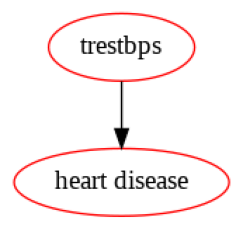

In [17]:
ft_index=1

ind_chosen_parent_features=np.array([ft_index])
ind_chosen_parent_features=[1]
bayes_net=construct_and_train_bayes_net(X_train_binned, y_train, ind_chosen_parent_features=[1])

# visualize
bayes_net.plot()

train_acc, val_acc=get_performance(bayes_net, X_train_binned, y_train, X_val_binned, y_val, ind_chosen_parent_features)
print(FEATURE_NAMES[ft_index])
print("train acc %.5f" %train_acc)
print("validation acc %.5f" %val_acc)

ca
train acc 0.73967
validation acc 0.72131


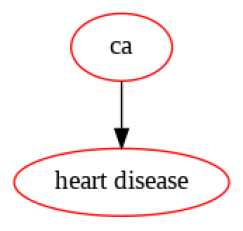

In [18]:
ft_index=5

ind_chosen_parent_features=np.array([ft_index])
bayes_net=construct_and_train_bayes_net(X_train_binned, y_train, ind_chosen_parent_features)

# visualize
bayes_net.plot()

train_acc,val_acc=get_performance(bayes_net, X_train_binned, y_train, X_val_binned, y_val, ind_chosen_parent_features)
print(FEATURE_NAMES[ft_index])
print("train acc %.5f" %train_acc)
print("validation acc %.5f" %val_acc)

#### Comment on which feature seems more informative for predicting the presence of heart disease. (1 point)

The ca (number of major vessels colored by flourosopy) seem more informative than the trestbps (resting blood pressure) given the corresponding bayes net has higher training and validation accuracy.

#### Exercise 2c: Construct a Bayes net with parent and children nodes (3 points)

#### Here, we'll implement a Bayes net with both parent nodes and children nodes.

#### Construct and train a Bayes net in which:
#### -the following features are all parents of the heart disease feature node (age, trestbps, chol).  
#### -the following features are all children of the heart disease feature node (thalach, oldpeak, ca).
#### Use construct_and_train_bayes_net by passing in the binned training dataset and specifying the indices of the parent feature nodes and indices of the children feature nodes.

#### Report the training and validation accuracy of the Bayes Net using get_performance by passing in the trained bayes net, binned datasets, and indices of the parent and children feature nodes.

train acc 0.77273
validation acc 0.78689


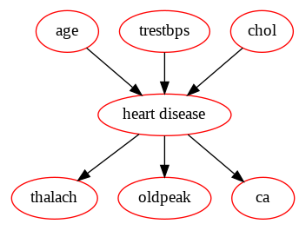

In [19]:
ind_chosen_parent_features=np.array([0,1,2])
ind_chosen_children_features=np.array([3,4,5])
bayes_net=construct_and_train_bayes_net(X_train_binned, y_train, ind_chosen_parent_features, ind_chosen_children_features)

# visualize
bayes_net.plot()

train_acc,val_acc=get_performance(bayes_net, X_train_binned, y_train, X_val_binned, y_val, 
                                   ind_chosen_parent_features,
                                  ind_chosen_children_features)
print("train acc %.5f" %train_acc)
print("validation acc %.5f" %val_acc)

#### Compare the performance of this Bayes net against the Bayes nets from Ex. 2b. (1 point)

The Bayes net from Ex. 2c attains higher training and validation accuracy than the Bayes nets from Ex. 2b, because this model incorporates more relevant features. 